In [65]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


In [66]:
dataset=pd.read_csv('/home/jibril/Documents/REvoEstatePricePrediction/EncodedFinalDataset.csv')
# dataset=pd.read_csv('/home/jibril/Documents/REvoEstatePricePrediction/NoDupFinaldatasetEncoded.csv')

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [68]:
from torcheval.metrics import R2Score


In [69]:
dataset.head(3)

,Price,Bedrooms,Bathrooms,Land_Area,Year,Status_For Rent,Status_For Sale,Furnished_No,Furnished_Yes,Address_Addis Ketema,...,Address_Bole,Address_Gullele,Address_Kirkos,Address_Kolfe Keranio,Address_Lemi Kura,Address_Lideta,Address_Nifas Silk-Lafto,Address_Yeka,Property_Type_Apartment,Property_Type_Villa
0,70000.0,1.0,2.0,148.0,2025.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,100000.0,3.0,2.0,148.0,2025.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31000000.0,5.0,3.0,350.0,2025.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [70]:
dataset.shape

(7659, 22)

In [71]:
# X=dataset[1:]
# Y=dataset[0]


In [72]:
# X[:5,:],Y[:5,:]

In [73]:
dataset=torch.tensor(dataset.values,dtype=torch.float32)
dataset.type

<function Tensor.type>

In [74]:
X=dataset[:,1:]
Y=dataset[:,0]
Y=Y.view(-1,1)


In [75]:
X[:3,:]

tensor([[1.0000e+00, 2.0000e+00, 1.4800e+02, 2.0250e+03, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00],
        [3.0000e+00, 2.0000e+00, 1.4800e+02, 2.0250e+03, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00],
        [5.0000e+00, 3.0000e+00, 3.5000e+02, 2.0250e+03, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [76]:
X.shape,Y.shape

(torch.Size([7659, 21]), torch.Size([7659, 1]))

In [77]:
# Y_log = torch.log1p(Y)  # log1p(Y) = ln(1 + Y) to handle zero or positive values

In [78]:
# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
# X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

In [79]:
X_train, X_test, Y_train_raw, Y_test_raw = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train_raw = torch.tensor(Y_train_raw, dtype=torch.float32)
Y_test_raw = torch.tensor(Y_test_raw, dtype=torch.float32)

n_synthetic = 5
extra_X = X_train[:n_synthetic].clone()
extra_X[:, 3] = torch.linspace(2026, 2030, n_synthetic)
extra_Y_raw = Y_train_raw[:n_synthetic] * (1 + 0.1 * (extra_X[:, 3] - 2025)).view(-1, 1)
X_train = torch.cat([X_train, extra_X], dim=0)
Y_train_raw = torch.cat([Y_train_raw, extra_Y_raw], dim=0)

# Normalize X
mean = X_train.mean(dim=0)
torch.save(mean, "mean.pt")
std = X_train.std(dim=0)
torch.save(std, "std.pt")
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Log-transform and normalize Y
Y_train_log = torch.log(Y_train_raw)
Y_test_log = torch.log(Y_test_raw)
Y_mean = Y_train_log.mean()
Y_std = Y_train_log.std()
Y_train = (Y_train_log - Y_mean) / Y_std
Y_test = (Y_test_log - Y_mean) / Y_std


# # Normalize Y
# Y_mean = Y_train_raw.mean()
# Y_std = Y_train_raw.std()
# Y_train = (Y_train_raw - Y_mean) / Y_std
# Y_test = (Y_test_raw - Y_mean) / Y_std



/tmp/ipykernel_8604/1271224318.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_8604/1271224318.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_8604/1271224318.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_raw = torch.tensor(Y_train_raw, dtype=torch.float32)
/tmp/ipykernel_8604/1271224318.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

In [95]:

torch.save(Y_std, "Y_std.pt")
torch.save(Y_mean, "Y_mean.pt")

In [81]:
# X_train=(X_train-mean)/std
# X_test=(X_test-mean)/std


In [82]:
# Y_mean = Y_train.mean()
# Y_std = Y_train.std()
# Y_train = (Y_train - Y_mean) / Y_std
# Y_test= (Y_test - Y_mean) / Y_std  

In [83]:
mean,std

(tensor([3.0662e+00, 2.5576e+00, 1.9919e+02, 2.0248e+03, 4.4912e-01, 5.5088e-01,
         5.3849e-01, 4.6151e-01, 1.0926e-02, 7.5016e-03, 2.3973e-02, 5.5561e-01,
         2.7723e-03, 6.9798e-02, 1.2231e-02, 6.0665e-02, 1.7613e-02, 4.9087e-02,
         1.8982e-01, 8.6057e-01, 1.3943e-01]),
 tensor([2.0612e+00, 1.5780e+00, 2.6704e+02, 4.3442e-01, 4.9744e-01, 4.9744e-01,
         4.9856e-01, 4.9856e-01, 1.0396e-01, 8.6294e-02, 1.5298e-01, 4.9694e-01,
         5.2584e-02, 2.5483e-01, 1.0992e-01, 2.3873e-01, 1.3155e-01, 2.1607e-01,
         3.9219e-01, 3.4643e-01, 3.4643e-01]))

In [84]:
X_train.mean(dim=0),X_train.std(dim=0)


(tensor([ 6.2210e-10, -9.9535e-09, -1.2131e-08, -8.0672e-05,  9.7358e-08,
          3.1105e-10,  6.0032e-08, -2.3018e-08,  8.7094e-09,  7.4652e-09,
          3.3904e-08, -6.5009e-08,  2.5428e-08,  4.0436e-08,  5.5989e-09,
          2.4884e-09,  3.5460e-08, -1.6175e-08,  5.4433e-09,  2.1151e-08,
         -2.1151e-08]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000]))

In [85]:
X_train.shape

torch.Size([6132, 21])

In [86]:


class RevoNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(21, 1024)
        self.fc2Seq = nn.Sequential(
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.GELU()
        )
        self.fc6 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2Seq(x)
        x = self.fc6(x)
        return x

In [87]:
# model=RevoNeuralNetwork()


In [88]:
# optimizer=torch.optim.Adam(model.parameters(),lr=0.0005,weight_decay=1e-4)
# lossfun = nn.HuberLoss(delta=0.167,reduction='mean')  

Epoch 0
Train Loss: 0.0517, Train MAE: 0.3429 LR: 0.0002
Test Loss: 0.0273, Test MAE: 0.2107 ,  R² Score: 0.2808
Epoch 10
Train Loss: 0.0206, Train MAE: 0.1689 LR: 0.0002
Test Loss: 0.0193, Test MAE: 0.1592 ,  R² Score: 0.3254
Epoch 20
Train Loss: 0.0187, Train MAE: 0.1580 LR: 0.0002
Test Loss: 0.0177, Test MAE: 0.1494 ,  R² Score: 0.3409
Epoch 30
Train Loss: 0.0175, Train MAE: 0.1493 LR: 0.0002
Test Loss: 0.0174, Test MAE: 0.1479 ,  R² Score: 0.3039
Epoch 40
Train Loss: 0.0169, Train MAE: 0.1464 LR: 0.0002
Test Loss: 0.0179, Test MAE: 0.1520 ,  R² Score: 0.3529
Epoch 50
Train Loss: 0.0164, Train MAE: 0.1436 LR: 0.0002
Test Loss: 0.0162, Test MAE: 0.1388 ,  R² Score: 0.3390
Epoch 60
Train Loss: 0.0155, Train MAE: 0.1377 LR: 0.0002
Test Loss: 0.0176, Test MAE: 0.1457 ,  R² Score: 0.3140
Epoch 70
Train Loss: 0.0153, Train MAE: 0.1358 LR: 0.0001
Test Loss: 0.0169, Test MAE: 0.1412 ,  R² Score: 0.3012
Epoch 80
Train Loss: 0.0145, Train MAE: 0.1302 LR: 0.0001
Test Loss: 0.0170, Test MAE: 0.

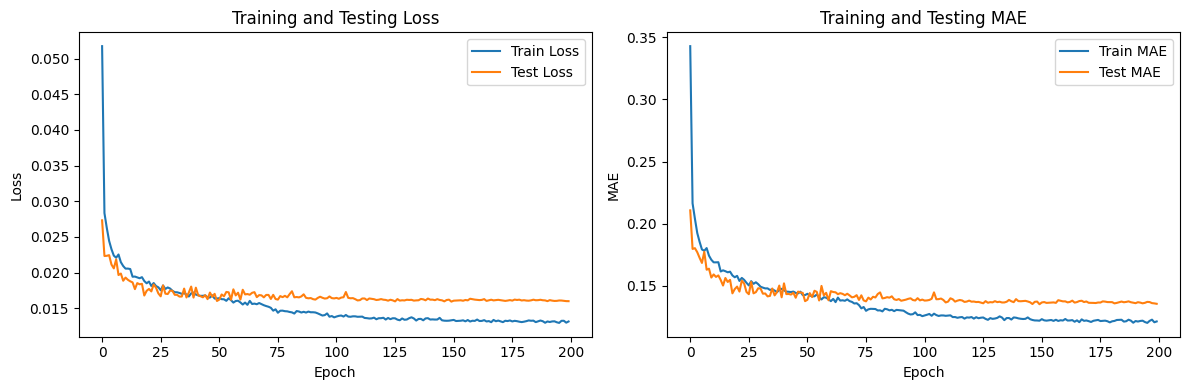


Final Results:
Final Train Loss: 0.0131
Final Test Loss: 0.0160
Final Train MAE: 0.1213
Final Test MAE: 0.1355


In [89]:
model=RevoNeuralNetwork()
model=model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0002,weight_decay=1e-5)
lossfun =nn.HuberLoss(delta=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

metric = R2Score().to(device)
trainLossavg = []
testLoss = []
rmsetest=[]
mapetest=[]
Rsqtest=[]
best_mae = float('inf')
patience = 50
counter = 0
trainMAEavg = []
testMAE = []

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Y_test_raw=Y_test_raw.to(device)

for epoch in range(200):
    batchLoss = []
    batchMAE= []
    batchtrainlossraw=[]

    # Training phase
    for x_train, y_train in train_loader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        model.train()
        y_pred = model(x_train)
        loss = lossfun(y_pred, y_train)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training MAE
        batch_mae = torch.mean(torch.abs(y_pred - y_train)).item()
        # batch_mae_raw = torch.mean(torch.abs(torch.exp(y_pred * Y_std + Y_mean) - torch.exp(y_train * Y_std + Y_mean))).item()
        batchLoss.append(loss.item())
        batchMAE.append(batch_mae)
        y_pred_test_raw = torch.exp(y_pred*Y_std + Y_mean)
        y_train_raw = torch.exp(y_train*Y_std + Y_mean)



    # Calculate average loss and MAE for the epoch
    trainLossavg.append(np.mean(batchLoss))
    trainMAEavg.append(np.mean(batchMAE))

    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        y_pred_test = model(X_test)
        y_pred_raw=torch.exp(y_pred_test * Y_std + Y_mean).to(device)
        # Huber Loss
        test_loss = lossfun(y_pred_test, Y_test)
        testLoss.append(test_loss.item())
        #MAE
        test_mae = torch.mean(torch.abs(y_pred_test - Y_test)).item()
        testMAE.append(test_mae)

       
        # R² Score

        metric.update(y_pred_raw, Y_test_raw)  # Update with predictions and targets
        r2 = metric.compute()                  # Compute R² score
        Rsqtest.append(r2.item())              # Store the scalar value
        metric.reset()




    scheduler.step(test_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}')

        print(f'Train Loss: {trainLossavg[-1]:.4f}, Train MAE: {trainMAEavg[-1]:.4f} LR: {optimizer.param_groups[0]["lr"]}')
        print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_mae:.4f} ,  R² Score: {r2.item():.4f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(trainLossavg, label='Train Loss')
plt.plot(testLoss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(trainMAEavg, label='Train MAE')
plt.plot(testMAE, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Testing MAE')
plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"Final Train Loss: {trainLossavg[-1]:.4f}")
print(f"Final Test Loss: {testLoss[-1]:.4f}")
print(f"Final Train MAE: {trainMAEavg[-1]:.4f}")
print(f"Final Test MAE: {testMAE[-1]:.4f}")

In [96]:
torch.save(model,"fullmodel.pth")
torch.save(model.state_dict(),"state_dictmodel.pth")

In [91]:
X_test.shape

torch.Size([1532, 21])

In [92]:
#38000.0,3.0,2.0,148.0,2024.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
#13000000.0,3.0,2.0,148.0,2024.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [94]:
raw_input =[1.0,1.0,39.0,2025.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0]
input_tensor = torch.tensor(raw_input, dtype=torch.float32).unsqueeze(0)
input_tensor_scaled = (input_tensor - mean) / std

model.eval()
with torch.no_grad():
    y_pred = model(input_tensor_scaled)
    y_pred_raw = torch.exp(y_pred * Y_std + Y_mean)  # Reverse log transformation
    print(f'Prediction: {y_pred_raw.item():.1f}')  


Prediction: 11373.0
